### データのダウンロード

In [ ]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 10.9 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a3c183efd99dde55e6ec09b79ecbaac2c6dd8dff1aac85d27ca16f8d915189a8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
requests 2.23.0 requires urllib3!

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Download 100%.


In [ ]:
! signate list
! signate files --competition-id=133
! signate download --competition-id=133

  competitionId  title                                                                             closing     prize        submitters
---------------  --------------------------------------------------------------------------------  ----------  ---------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                              -                              5893
             24  【練習問題】お弁当の需要予測                                                      -                              7340
             27  【練習問題】Jリーグの観客動員数予測                                               -                              1763
            100  【練習問題】手書き文字認識                                                        -           Knowledge           226
            102  【練習問題】タイタニックの生存予測                                                -           Knowledge          1686
            103  【練習問題】音楽ラベリング                                                        -           Knowledge            98
            

In [ ]:
!unzip -q train_images.zip

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/cifar10/notebooks

/content/drive/MyDrive/Colab Notebooks/cifar10/notebooks


In [ ]:
!pip install -q timm

     |████████████████████████████████| 509 kB 8.0 MB/s 
     |████████████████████████████████| 127 kB 92.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
signate 0.9.9 requires urllib3>=1.26.7, but you have urllib3 1.25.11 which is incompatible.


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim

import timm

from src import (
    colab_save_model, set_device, seed_torch,
    DataTransform, CifarDataset, make_dataloader,
    EarlyStopping, train_model
)


In [ ]:
device = set_device()

device：cuda


In [ ]:
seed_torch()

set random seed


In [ ]:
smp = colab_save_model(True, attach_path='/content/drive/MyDrive/Colab Notebooks/cifar10')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Save model path: /content/drive/MyDrive/Colab Notebooks/cifar10/model/


### データの読み込み

In [ ]:
# read label data
train_master = pd.read_csv('/content/train_master.tsv', sep='\t')
print(train_master.head())
print('データ数: ', train_master.shape[0])

     file_name  label_id
0  train_0.jpg         1
1  train_1.jpg         5
2  train_2.jpg         1
3  train_3.jpg         6
4  train_4.jpg         3
データ数:  5000


In [ ]:
# image name list
image_name_list = train_master['file_name'].values
print('データ数: ', len(image_name_list))

# label list
label_list = train_master['label_id'].values

データ数:  5000


In [ ]:
# split train & val
x_train, x_val, y_train, y_val = train_test_split(image_name_list, label_list, test_size=0.25, stratify=label_list, random_state=42)

In [ ]:
# dataset
train_dataset = CifarDataset(x_train, y_train, '/content/train_images',transform=DataTransform(), phase='train')
val_dataset = CifarDataset(x_val, y_val, '/content/train_images', transform=DataTransform(), phase='val')

In [ ]:
dataloader = make_dataloader(train_dataset, val_dataset, 64, 64)

### モデルの定義

In [ ]:
model = timm.create_model('convnext_base', pretrained=True, num_classes=10)
model.to(device)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate=none)
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), e

In [ ]:
# loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)

In [ ]:
ers = EarlyStopping(patience=20, verbose=1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-5, verbose=True)

Epoch: 1 / 100
--------------------------
train Loss: 0.7895 Accuracy: 0.7536
val Loss: 0.3159 Accuracy: 0.9008
Epoch: 2 / 100
--------------------------
train Loss: 0.4375 Accuracy: 0.8563
val Loss: 0.3781 Accuracy: 0.8760
Epoch: 3 / 100
--------------------------
train Loss: 0.3628 Accuracy: 0.8800
val Loss: 0.3090 Accuracy: 0.9016
Epoch: 4 / 100
--------------------------
train Loss: 0.3020 Accuracy: 0.8960
val Loss: 0.3152 Accuracy: 0.8976
Epoch: 5 / 100
--------------------------
train Loss: 0.2877 Accuracy: 0.9104
val Loss: 0.4475 Accuracy: 0.8520
Epoch: 6 / 100
--------------------------
train Loss: 0.2728 Accuracy: 0.9104
val Loss: 0.4023 Accuracy: 0.8672
Epoch: 7 / 100
--------------------------
train Loss: 0.2890 Accuracy: 0.9043
val Loss: 0.4623 Accuracy: 0.8728
Epoch: 8 / 100
--------------------------
train Loss: 0.2590 Accuracy: 0.9128
val Loss: 0.3905 Accuracy: 0.8808
Epoch: 9 / 100
--------------------------
train Loss: 0.2724 Accuracy: 0.9080
val Loss: 0.4596 Accuracy:

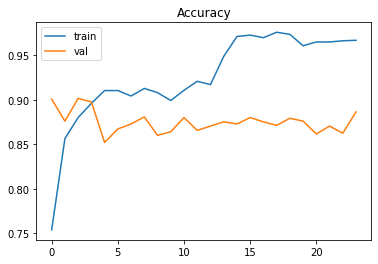

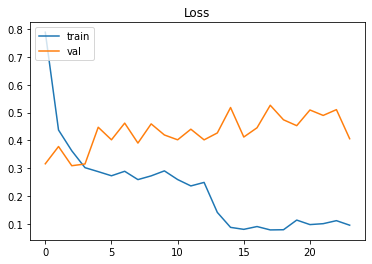

In [ ]:
train_model(model, 100, dataloader, device, criterion, optimizer, scheduler, ers, smp, 'convnext_base')